In [2]:
df = spark.read.csv('beer_ratings.txt', sep='\t', header = None, inferSchema=True)
print(df.show(10))
print(df.printSchema())

+-----------+---+----+-----+------+------+------+---+------+----+------+-------+
|        _c0|_c1| _c2|  _c3|   _c4|   _c5|   _c6|_c7|   _c8| _c9|  _c10|   _c11|
+-----------+---+----+-----+------+------+------+---+------+----+------+-------+
|4.476190476| 60|10.4|  0.5|1.6268| 15.75| 66.47| 41|0.9678|3.72|11.825| 44.375|
|4.523809524| 61|10.3| 0.53|1.6268| 15.12|67.252| 26|0.9676|3.73| 13.76|  36.25|
|4.714285714| 61|11.5| 0.74|0.7968| 17.64| 82.11| 32|0.9698|3.74|14.405|16.5625|
|5.238095238| 60| 8.4|0.465|1.6268| 15.75|68.816| 42|0.9666|3.86| 16.77| 33.125|
|4.476190476| 60|11.0| 0.73|0.7968| 15.12|60.214|  9|0.9674|3.59|12.255|10.3125|
|4.904761905| 59|13.0| 0.48|1.6268| 17.01|76.636| 15|0.9704|3.66|13.115| 13.125|
|4.904761905| 61|13.0| 0.48|1.6268| 17.01|76.636| 15|0.9704|3.66|13.115| 13.125|
|4.476190476| 60|11.0| 0.73|0.7968| 15.12|60.214|  9|0.9674|3.59|12.255|10.3125|
|5.333333333| 59|12.3|  0.6|2.4568|32.445|  78.2|  8|0.9696|3.72| 13.33| 5.3125|
|4.571428571| 58|10.3| 0.69|

In [4]:
df = df.withColumnRenamed('_c0', 'alcohol_by_weight')\
        .withColumnRenamed('_c1', 'rating')\
        .withColumnRenamed('_c2', 'bitterness')\
        .withColumnRenamed('_c3', 'nitrogen')\
        .withColumnRenamed('_c4', 'turbidity')\
        .withColumnRenamed('_c5', 'sugars')\
        .withColumnRenamed('_c6', 'degree_of_fermentation')\
        .withColumnRenamed('_c7', 'calorific_value')\
        .withColumnRenamed('_c8', 'density')\
        .withColumnRenamed('_c9', 'pH')\
        .withColumnRenamed('_c10', 'colour')\
        .withColumnRenamed('_c11', 'sulphites')

df.printSchema()

root
 |-- alcohol_by_weight: double (nullable = true)
 |-- rating: integer (nullable = true)
 |-- bitterness: double (nullable = true)
 |-- nitrogen: double (nullable = true)
 |-- turbidity: double (nullable = true)
 |-- sugars: double (nullable = true)
 |-- degree_of_fermentation: double (nullable = true)
 |-- calorific_value: integer (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- colour: double (nullable = true)
 |-- sulphites: double (nullable = true)



In [5]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols = ['alcohol_by_weight', 'bitterness', 'nitrogen', 'turbidity', 'sugars','degree_of_fermentation', 'calorific_value', \
                                         'density', 'pH', 'colour', 'sulphites'], outputCol = 'features')

In [13]:
df_assembled = assembler.transform(df)
df_assembled.select('features', 'rating').show(5)

+--------------------+------+
|            features|rating|
+--------------------+------+
|[4.476190476,10.4...|    60|
|[4.523809524,10.3...|    61|
|[4.714285714,11.5...|    61|
|[5.238095238,8.4,...|    60|
|[4.476190476,11.0...|    60|
+--------------------+------+
only showing top 5 rows



In [16]:
df.corr('alcohol_by_weight', 'bitterness')

-0.01682403143450895

In [35]:
# import plotly.plotly as py
from chart_studio.plotly import plot, iplot
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df_plot = df.select('alcohol_by_weight', 'bitterness', 'nitrogen', 'turbidity', 'sugars','degree_of_fermentation', 'calorific_value', \
                                         'density', 'pH', 'colour', 'sulphites', 'rating').toPandas()

fig = make_subplots(
    rows=2, cols=1,
    row_heights=[1, 0.33],
    start_cell="top-left")

fig.add_scatter(y =df_plot.rating, x=df_plot.bitterness, row=1, col=1)
fig.show()

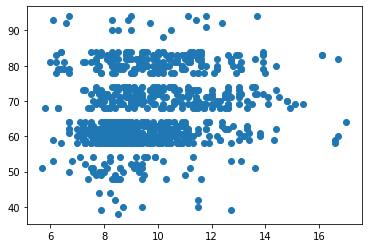

In [9]:

%matplotlib inline
import matplotlib.pyplot as plt
df_pd = df.toPandas()
plt.scatter(df_pd.bitterness, y=df_pd.rating)

In [14]:
train, test = df_assembled.randomSplit([0.7,0.3], seed = 100)

In [25]:
from pyspark.ml.feature import StandardScalerModel, StandardScaler
# standardizer = StandardScaler(inputCol = 'bitterness', outputCol = 'scaled_bitterness')
# model = standardizer.fit(train)
# result = model.transform(train)
def Scale(data):
    Scalerizer=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
    scaled_df = Scalerizer.fit(data).transform(data)
#     scaled_df.select('features', 'Scaled_features').show()
    return data

In [26]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Create a regression object and train on training data
regression = LinearRegression(labelCol = 'rating').fit(Scale(train))

In [27]:
predictions = regression.transform(test)
predictions.select('rating', 'prediction').show(5, False)

+------+------------------+
|rating|prediction        |
+------+------------------+
|70    |63.259623936294076|
|39    |60.436459345986805|
|48    |59.839044590706465|
|49    |60.26924662832698 |
|62    |63.86787737131351 |
+------+------------------+
only showing top 5 rows



In [28]:
RegressionEvaluator(labelCol='rating').evaluate(predictions)

7.642689490814304

In [29]:
from pyspark.mllib.evaluation import RegressionMetrics

predictions_eval = predictions.select('prediction', 'rating')

predictions_eval = predictions_eval.selectExpr("cast(prediction as double) prediction",
                                                "cast(rating as double) rating")

metrics = RegressionMetrics(predictions_eval.rdd)

print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)

# R-squared
print("R-squared = %s" % metrics.r2)

# Mean absolute error
print("MAE = %s" % metrics.meanAbsoluteError)

# Explained variance
print("Explained variance = %s" % metrics.explainedVariance)

MSE = 58.4107026530034
RMSE = 7.642689490814304
R-squared = 0.401686083500049
MAE = 6.020356881382232
Explained variance = 46.70097392778868


In [22]:
regression_ridge = LinearRegression(labelCol='rating', elasticNetParam=0)

In [23]:
regression_ridge = LinearRegression(labelCol='rating', elasticNetParam=0).fit(train)
predictions_ridge = regression_ridge.transform(test)
predictions_ridge.select('rating', 'prediction').show(5, False)

predictions_eval_ridge = predictions_ridge.select('prediction', 'rating')

predictions_eval_ridge = predictions_eval_ridge.selectExpr("cast(prediction as double) prediction",
                                                "cast(rating as double) rating")

metrics = RegressionMetrics(predictions_eval_ridge.rdd)
print("Ridge Regression")
print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)

# R-squared
print("R-squared = %s" % metrics.r2)

# Mean absolute error
print("MAE = %s" % metrics.meanAbsoluteError)

# Explained variance
print("Explained variance = %s" % metrics.explainedVariance)

+------+------------------+
|rating|prediction        |
+------+------------------+
|70    |63.259623936294076|
|39    |60.436459345986805|
|48    |59.839044590706465|
|49    |60.26924662832698 |
|62    |63.86787737131351 |
+------+------------------+
only showing top 5 rows

Ridge Regression
MSE = 58.4107026530034
RMSE = 7.642689490814304
R-squared = 0.401686083500049
MAE = 6.020356881382232
Explained variance = 46.70097392778868


In [31]:
regression_lasso = LinearRegression(labelCol='rating', elasticNetParam=1, regParam = 0.5).fit(train)
predictions_lasso = regression_lasso.transform(test)
predictions_lasso.select('rating', 'prediction').show(5, False)

predictions_eval_lasso = predictions_lasso.select('prediction', 'rating')

predictions_eval_lasso = predictions_eval_lasso.selectExpr("cast(prediction as double) prediction",
                                                "cast(rating as double) rating")

metrics = RegressionMetrics(predictions_eval_lasso.rdd)
print("Lasso Regression")
print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)

# R-squared
print("R-squared = %s" % metrics.r2)

# Mean absolute error
print("MAE = %s" % metrics.meanAbsoluteError)

# Explained variance
print("Explained variance = %s" % metrics.explainedVariance)

print("Coefficients", regression_lasso.coefficients)

+------+------------------+
|rating|prediction        |
+------+------------------+
|70    |63.56992657783307 |
|39    |61.27938753109501 |
|48    |60.02294417266923 |
|49    |60.581640623901926|
|62    |63.63979581789529 |
+------+------------------+
only showing top 5 rows

Lasso Regression
MSE = 58.85892743026022
RMSE = 7.671957209881988
R-squared = 0.3970948166641405
MAE = 6.155264275341345
Explained variance = 35.962523542386876
Coefficients [7.191740195988031,0.0,-14.711567411124925,0.0,0.0,-0.013368537953692531,0.0,0.0,-3.8171121614277075,0.3734413414178415,-0.01322248456219897]


In [34]:
print("Lasso Coefficients", regression_lasso.coefficients, "\n")
print("Ridge Coefficients", regression_ridge.coefficients, "\n")
print("Regression Coefficients", regression.coefficients)

Lasso Coefficients [7.191740195988031,0.0,-14.711567411124925,0.0,0.0,-0.013368537953692531,0.0,0.0,-3.8171121614277075,0.3734413414178415,-0.01322248456219897] 

Ridge Coefficients [6.764296738455038,0.2955550345774243,-14.517314868609391,-0.25148694822834133,0.05171126472188426,-0.03726414950683073,0.006968109238765978,-410.93459918178314,-7.094347614086094,0.6022146466395646,-0.07059341401066876] 

Regression Coefficients [6.764296738455038,0.2955550345774243,-14.517314868609391,-0.25148694822834133,0.05171126472188426,-0.03726414950683073,0.006968109238765978,-410.93459918178314,-7.094347614086094,0.6022146466395646,-0.07059341401066876]


In [33]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(labelCol='rating',maxDepth=3,maxBins=30).fit(train)
predictions_dt = dt.transform(test)
pred_dt = predictions_dt.select('rating', 'prediction')
pred_dt = pred_dt.selectExpr("cast(prediction as double) prediction",
                                                "cast(rating as double) rating")
metrics = RegressionMetrics(pred_dt.rdd)
print("Decision Tree - Test Score")
print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)

# R-squared
print("R-squared = %s" % metrics.r2)

# Mean absolute error
print("MAE = %s" % metrics.meanAbsoluteError)

# Explained variance
print("Explained variance = %s" % metrics.explainedVariance)


Decision Tree - Test Score
MSE = 66.96178157021143
RMSE = 8.18301787668898
R-squared = 0.31409546594407567
MAE = 6.184881671559556
Explained variance = 45.272286084158075


In [32]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(labelCol='rating',maxDepth=3,maxBins=30).fit(train)
predictions_dt = dt.transform(train)
pred_dt = predictions_dt.select('rating', 'prediction')
pred_dt = pred_dt.selectExpr("cast(prediction as double) prediction",
                                                "cast(rating as double) rating")
metrics = RegressionMetrics(pred_dt.rdd)
print("Decision Tree - Training Score")
print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)

# R-squared
print("R-squared = %s" % metrics.r2)

# Mean absolute error
print("MAE = %s" % metrics.meanAbsoluteError)

# Explained variance
print("Explained variance = %s" % metrics.explainedVariance)


Decision Tree - Training Score
MSE = 56.856810577279
RMSE = 7.540345521080516
R-squared = 0.44451605727153964
MAE = 5.650938168226302
Explained variance = 45.49864239586401


In [49]:
pred_dt.show(10)

+------+-----------------+
|rating|       prediction|
+------+-----------------+
|    70|67.48366013071896|
|    39|64.42105263157895|
|    48|60.94845360824742|
|    49|64.42105263157895|
|    62|64.42105263157895|
|    69|67.48366013071896|
|    70|67.48366013071896|
|    71|67.48366013071896|
|    73|60.18181818181818|
|    74|67.48366013071896|
+------+-----------------+
only showing top 10 rows

